# The Gap Statistic

An alternative to using the elbow method to decide the optimal number of clusters (K) is the Gap statistic. The statistic gives us a way to get an optimal amount of clusters without having to use our eyes.

This method makes use of the within-cluster point scatter. In this case the dissimilarity function is the eucledian distance.

$ W_k = \sum_{k=1}^K\frac{1}{2n_k}D_k $

where 

$ D_k = 2n_k\sum_{x_i\in C_k}||x_i-\mu_k||^2 $

This within-cluster dispersion, $W_k$, is also used in the elbow approach. When finding the gap statistic we compare the $W_k$ found in our sample data, with one from a reference null distribution.

We define the gap statistic as

$ Gap_n(k) = E_n^*(\log(W_k)) - \log(W_k) $

Where $E_n^*$ denotes the expectation under a sample of size n from the reference distribution.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import CreateDataFunctions as df

Xdat, Ydat = df.Data1()

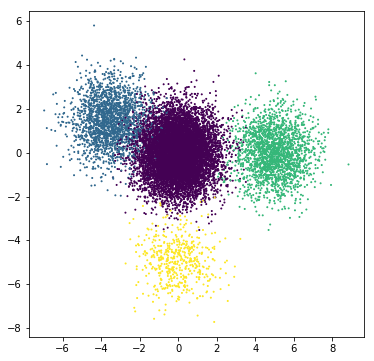

In [2]:
plt.figure(figsize=(6,6)) 
plt.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
plt.show()

### Creating a uniform distrubution inside the boundary of the clusters

In [3]:
def bounding_box(data):
    xMin, yMin = min(data[:,0]), min(data[:,1])
    xMax, yMax = max(data[:,0]), max(data[:,1])
    return xMin,xMax, yMin, yMax

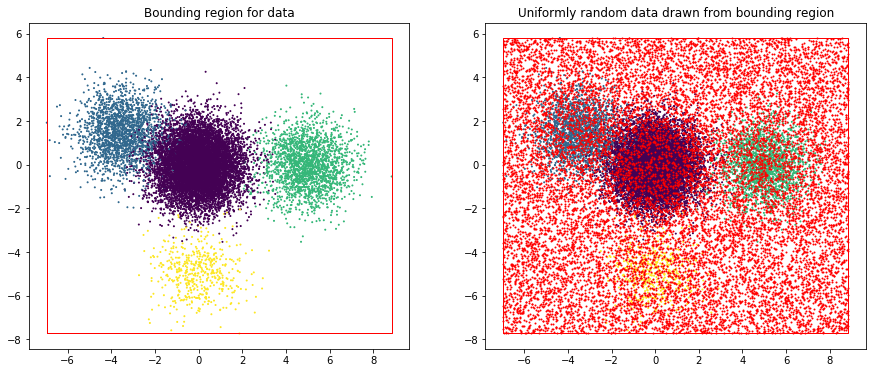

In [4]:
f, (ax1,ax2) = plt.subplots(1, 2)

f.set_figheight(6)
f.set_figwidth(15)

xMin,xMax,yMin,yMax = bounding_box(Xdat)
ax1.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
ax1.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
ax1.set_title('Bounding region for data')

Random_Xdat = np.transpose(np.array([np.random.uniform(xMin,xMax,int(len(Xdat))), \
                                     np.random.uniform(yMin,yMax,int(len(Xdat)))]))

ax2.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
ax2.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
ax2.scatter(Random_Xdat[:,0],Random_Xdat[:,1], c='r',s=1)
ax2.set_title('Uniformly random data drawn from bounding region')

plt.show()



### Trying out the Kmeans clustering library

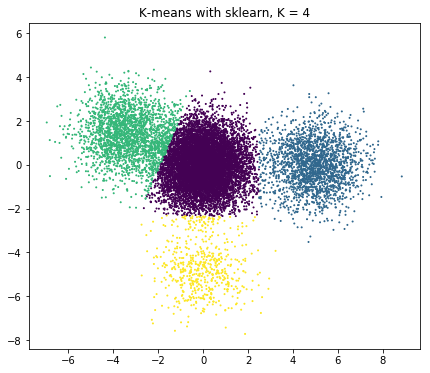

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Xdat)
plt.figure(figsize=(7,6)) 
plt.scatter(Xdat[:,0],Xdat[:,1], c=kmeans.labels_,s=1) 
plt.title("K-means with sklearn, K = 4")
plt.show()

### Plot the within-cluster point scatter for K-means on the real data and uniform data

In [6]:
def withinClusterScatter(clusters, mu):
    K = len(mu)
    res = sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) \
               for i in range(K) for c in clusters[i]])
    return res

def getClustersFromKMean(labels, data, nrClusters):
    clusters = []
    
    for i in range(nrClusters):
        clusters.append(data[labels == i])
        
    return clusters


def get_gap_statistic(data):
    
    B = 10 # number of reference 
    Ks = range(1,11) 
    wk_real_data = np.zeros(len(Ks))
    wk_reference_data = np.zeros(len(Ks))
    sk = np.zeros(len(Ks))
    nrDataPoints = len(Xdat)

    for iK, K in enumerate(Ks):

        # We generate 10 reference data sets with K clusters and check Wk
        wk_bs = np.zeros(B);
        for i in range(B):
            random_Xdat = np.transpose(np.array([np.random.uniform(xMin, xMax, nrDataPoints), \
                                         np.random.uniform(yMin, yMax, nrDataPoints)]))

            kmeans_unif_data = KMeans(n_clusters=K, random_state=0).fit(random_Xdat)
            clusters_unif = getClustersFromKMean(kmeans_unif_data.labels_, random_Xdat, K);
            wk_unif = withinClusterScatter(clusters_unif, kmeans_unif_data.cluster_centers_)
            wk_bs[i] = np.log(wk_unif)

        wk_reference_data[iK] = sum(wk_bs)/B

        sk[iK] = np.sqrt(sum((wk_bs - wk_reference_data[iK])**2)/B)

        # Calculate Wk for real data
        kmeans_real_data = KMeans(n_clusters=K, random_state=0).fit(Xdat)
        clusters_real = getClustersFromKMean(kmeans_real_data.labels_, Xdat, K);

        wk_real_log = np.log(withinClusterScatter(clusters_real, kmeans_real_data.cluster_centers_))

        wk_real_data[iK] = wk_real_log

    sk = sk*np.sqrt(1+1/B)
    
    return wk_real_data, wk_reference_data, sk, Ks

wk_real_data, wk_reference_data, sk, Ks = get_gap_statistic(Xdat)

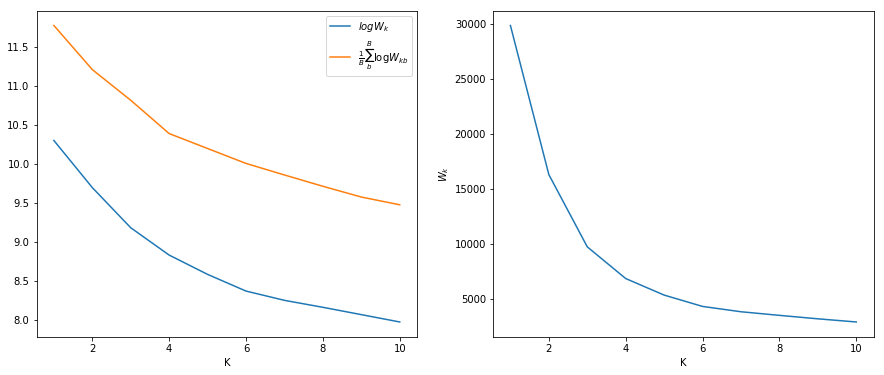

In [7]:
f, (ax1,ax2) = plt.subplots(1, 2)

f.set_figheight(6)
f.set_figwidth(15)

ax1.plot(Ks, wk_real_data, label=r"$log W_k$")
ax1.plot(Ks, wk_reference_data, label=r"$\frac{1}{B}\sum^{B}_{b}\log W_{kb}$")
ax1.legend(loc='upper right')
ax1.set_xlabel("K")


ax2.plot(Ks, np.exp(wk_real_data))
ax2.set_xlabel("K")
ax2.set_ylabel(r"$W_k$")


plt.show()


We are looking for the smallest $k$ such that $Gap(k) \geq Gap(k+1) - s_{k+1}$

In [8]:
for iK, K in enumerate(Ks[:-1]):
    gap = wk_reference_data[iK] - wk_real_data[iK];
    gap_next = wk_reference_data[iK+1] - wk_real_data[iK+1]
    if  (gap >= gap_next - sk[iK]):
        print("Optimal k: {}".format(K))
        break

Optimal k: 3


The optimal K is calculated to be 3. Using the elbow method, it may be reasonable to come to the same conclusion. It is not correct however and it might have to do with the overlap between the clusters. 

Next we'll try it on a dataset which has greater separation of the clusters.